In [1]:
from d2l import torch as d2l
import torch
import math
import numpy as np
from torch import nn

In [2]:
max_degree = 20

n_train, n_test = 100, 100

true_w = np.zeros(max_degree)

true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))

np.random.shuffle(features)

poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)

labels = np.dot(poly_features, true_w)

labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.2979],
         [-0.0919]]),
 tensor([[ 1.0000e+00, -2.9793e-01,  4.4380e-02, -4.4074e-03,  3.2827e-04,
          -1.9560e-05,  9.7126e-07, -4.1338e-08,  1.5395e-09, -5.0961e-11,
           1.5183e-12, -4.1121e-14,  1.0209e-15, -2.3397e-17,  4.9790e-19,
          -9.8893e-21,  1.8414e-22, -3.2271e-24,  5.3414e-26, -8.3756e-28],
         [ 1.0000e+00, -9.1931e-02,  4.2256e-03, -1.2949e-04,  2.9760e-06,
          -5.4718e-08,  8.3837e-10, -1.1010e-11,  1.2652e-13, -1.2924e-15,
           1.1881e-17, -9.9294e-20,  7.6068e-22, -5.3792e-24,  3.5323e-26,
          -2.1648e-28,  1.2438e-30, -6.7263e-33,  3.4353e-35, -1.6622e-37]]),
 tensor([4.5612, 4.8521]))

In [4]:
def evaluate_loss(net, data_iter,loss):

    metric = d2l.Accumulator(2)

    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())

    return metric[0] / metric[1]


def train(train_features, test_features, train_labels, test_labels, num_epochs=400):

    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size , is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.0042925  1.2089456 -3.3933487  5.58591  ]]


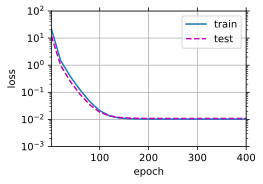

In [5]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.3569503 4.1644073]]


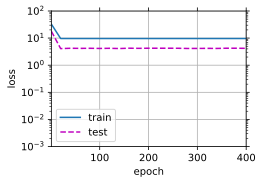

In [6]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9967337   1.3065846  -3.348011    5.1389837  -0.14555287  0.9986897
  -0.1143266   0.19922757 -0.20210789  0.17180096  0.20740172  0.07728795
  -0.0822754  -0.18576981 -0.18522987 -0.0322477  -0.06006163 -0.16901277
  -0.01182658  0.05933651]]


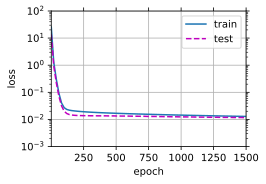

In [7]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)